In [1]:
!pip install -q ultralytics

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Aky0gjFut9dGmA4ZUUCO")
project = rf.workspace("project-lg09m").project("cell-phones-cjf5o")
dataset = project.version(7).download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.134 is required but found version=8.0.184, to fix: `pip install ultralytics==8.0.134`



Extracting Dataset Version Zip to Cell-Phones-7 in yolov8:: 100%|██████████| 1872/1872 [00:00<00:00, 4445.07it/s]


# YOLO

In [ ]:
!cat ./Cell-Phones-7/data2.yaml

In [5]:
s = """names:
- cell phones
nc: 1
roboflow:
  license: CC BY 4.0
  project: cell-phones-cjf5o
  url: https://universe.roboflow.com/project-lg09m/cell-phones-cjf5o/dataset/4
  version: 4
  workspace: project-lg09m
test: ../test/images
train: ../train/images
val: ../valid/images"""


with open('./Cell-Phones-7/data2.yaml', 'w') as f:
    f.write(s)

In [7]:
import os
os.environ['WANDB_DISABLED'] = 'true'

In [22]:
%cd ..

/kaggle/working


In [10]:
dataset.location

'/kaggle/working/Cell-Phones-4'

In [13]:
import torch
torch.cuda.is_available()

True

In [10]:
!cat /root/.config/Ultralytics/settings.yaml

settings_version: 0.0.4
datasets_dir: /kaggle/working
weights_dir: weights
runs_dir: runs
uuid: 1bfc3e992d24318da58ddee183be5bf9388a31f26bab1738e986ec4d297417ff
sync: true
api_key: ''
clearml: true
comet: true
dvc: true
hub: true
mlflow: true
neptune: true
raytune: true
tensorboard: true
wandb: true

In [9]:
s = """settings_version: 0.0.4
datasets_dir: /kaggle/working
weights_dir: weights
runs_dir: runs
uuid: 1bfc3e992d24318da58ddee183be5bf9388a31f26bab1738e986ec4d297417ff
sync: true
api_key: ''
clearml: true
comet: true
dvc: true
hub: true
mlflow: true
neptune: true
raytune: true
tensorboard: true
wandb: true"""

with open('/root/.config/Ultralytics/settings.yaml', 'w') as f:
    f.write(s)

In [ ]:
!yolo task=detect mode=train model=yolov8x.pt data=./Cell-Phones-7/data2.yaml epochs=70 plots=False device=0,1 pretrained=False imgsz=800 batch=16

# Bruh

In [ ]:
!pip install -q ultralytics

In [10]:
import pandas as pd
from ultralytics import YOLO
import cv2
import time
import torch

ModuleNotFoundError: No module named 'ultralytics'

In [ ]:
def plot_boxes(frame, xyxy, label):  # plot detected class box
    x1 = int(xyxy[0])
    y1 = int(xyxy[1])
    x2 = int(xyxy[2])
    y2 = int(xyxy[3])

    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    frame = cv2.rectangle(frame, (x1, y1 - 20), (x1 + w, y1), (0,0,255), -1)
    frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
    frame = cv2.putText(frame, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    return frame

def save_handled_frame(frame_id, saved_video_path, img_save_path):  # save image from saved video with detections
    cap = cv2.VideoCapture(saved_video_path)
    count = 1
    success, frame = cap.read()

    while count != frame_id:
        count += 1
        success, frame = cap.read()

    cv2.imwrite(f'{img_save_path}/detection_frame_{frame_id}.jpg', frame)
    print('image was saved')


class AttentionModel:
    def __init__(self):
        self.models_keys = {
            'detection': '/kaggle/working/runs/detect/train2/weights/best.pt',  # use yolov8x.pt
            'pos_estimation': 'models/yolov8x-pose.pt'
        }

        # models
        self.detect_model = None,
        self.detect_model_classes = None
        self.pos_est_model = None

        # result data
        self.detected_data = pd.DataFrame(
            columns=['Frame_id', 'Time', 'Objects_class', 'Position'],
        )

        # video parameters
        self.video_type = 'avi'  # saved video type
        self.fps = 30
        self.sec_per_frame = 1 / self.fps


    def load_models(self):
        self.detect_model = YOLO(self.models_keys['detection'])
        self.detect_model_classes = self.detect_model.names

        self.pos_est_model = YOLO(self.models_keys['pos_estimation'])

        if torch.cuda.is_available():
            self.detect_model.to('cuda')
            self.pos_est_model.to('cuda')


    def handle_detection(self, results, frame, frame_id):
        detected_classes = []
        detected_positions = dict()

        for result in results:
            boxes = result.boxes.cpu().numpy()

            for box in boxes:
                class_name = self.detect_model_classes[int(box.cls)]
                detected_classes.append(str(class_name))
                confidence = str(round(box.conf[0].item(), 2))
                label = f'{class_name}: {confidence}'

                xyxy = box.xyxy[0]
                frame = plot_boxes(frame, xyxy, label)

                if not class_name in detected_positions.keys():
                    detected_positions[class_name] = []
                detected_positions[class_name].append(xyxy)

        detected_classes = set(detected_classes)

        if detected_classes:
            detection_time = frame_id * self.sec_per_frame
            self.detected_data.loc[len(self.detected_data.index)] = [frame_id, detection_time, detected_classes, detected_positions]

        return frame


    def handle_pos_est(self, results, frame, frame_id):
        # plot_pos_points
        return


    def predict(self, data_path, out_path, detection=True, pos_estimation=False):
        cap = cv2.VideoCapture(data_path)

        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))

        codec = cv2.VideoWriter_fourcc('M','J','P','G')  # avi format
        out = cv2.VideoWriter(out_path , codec, self.fps, (frame_width, frame_height))

        start = time.time()

        success, frame = cap.read()
        frame_count = 0

        while success:
            frame_count += 1

            if detection:
                detection_results = self.detect_model(frame, verbose=False)
                frame = self.handle_detection(detection_results, frame, frame_count)

            if pos_estimation:
                pos_est_results = self.pos_est_model(frame, verbose=False)
                frame = self.handle_pos_est(pos_est_results, frame, frame_count)

            out.write(frame)
            if frame_count >= 100:
                break
            success, frame = cap.read()
        
        cap.release()
        out.release()
        
        end = time.time() - start
        print(f'Time: {end}')

    def get_detected_data(self):
        return self.detected_data

    def clear_data(self):  # clear detected_data
        self.detected_data = self.detected_data.iloc[0:0]


In [ ]:
OUT_PATH = './model_output_video_11.avi' # your video path for saving
DATA_PATH = '/kaggle/input/train-crew-video/01_16_15.mp4' # your video path for processing
SAVE_IMG_PATH = '.'

In [ ]:
model = AttentionModel()
model.load_models()

In [ ]:
model.predict(DATA_PATH, OUT_PATH)

In [23]:
model = YOLO('/kaggle/working/runs/detect/train2/weights/best.pt')
model.to('cuda')
result = model.predict(DATA_PATH, stream=True, save=True, verbose=False)

In [59]:
# pose-estimator
heavy_model = YOLO('models/yolov8x-pose.pt')
heavy_model.to('cuda')
heavy_model.predict(DATA_PATH, stream=False, save=True)

FileNotFoundError: /kaggle/input/train-crew-video/00_22_16_short.mp4 does not exist

In [2]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Aky0gjFut9dGmA4ZUUCO")
project = rf.workspace("project-lg09m").project("cell-phones-cjf5o")
dataset = project.version(3).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cell-Phones-3 in coco:: 100%|██████████| 1122/1122 [00:00<00:00, 3574.70it/s]


In [4]:
dataset.location

'/kaggle/working/Cell-Phones-3'

In [11]:
!pip install -q ultralytics

In [19]:
!yolo task=detect mode=predict model='yolov8x-pose.pt' source='/kaggle/input/train-crew-video/photo_2023-09-22_12-29-40.jpg' save=True device=0,1

100%|█████████████████████████████████████████| 133M/133M [00:00<00:00, 172MB/s]
WARNING ⚠️ conflicting 'task=detect' passed with 'task=pose' model. Ignoring 'task=detect' and updating to 'task=pose' to match model.
Ultralytics YOLOv8.0.184 🚀 Python-3.10.12 torch-2.0.0 CUDA:0 (Tesla T4, 15110MiB)
                                                       CUDA:1 (Tesla T4, 15110MiB)
YOLOv8x-pose summary (fused): 287 layers, 69462204 parameters, 0 gradients

image 1/1 /kaggle/input/train-crew-video/photo_2023-09-22_12-29-40.jpg: 384x640 2 persons, 94.7ms
Speed: 3.0ms preprocess, 94.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
Results saved to runs/pose/predict
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [136]:
!pip install -q ultralytics

In [639]:
import time

import cv2
import pandas as pd
import torch
from tqdm import tqdm
from ultralytics import YOLO


def plot_boxes(frame, xyxy, label):  # plot detected class box
    x1 = int(xyxy[0])
    y1 = int(xyxy[1])
    x2 = int(xyxy[2])
    y2 = int(xyxy[3])

    (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)
    frame = cv2.rectangle(frame, (x1, y1 - 20), (x1 + w, y1), (0,0,255), -1)
    frame = cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 1)
    frame = cv2.putText(frame, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    return frame

def save_handled_frame(frame_id, saved_video_path, img_save_path):
    cap = cv2.VideoCapture(saved_video_path)
    count = 1
    success, frame = cap.read()

    while count != frame_id:
        count += 1
        success, frame = cap.read()

    cv2.imwrite(f'{img_save_path}/detection_frame_{frame_id}.jpg', frame)
    print('image was saved')


class AttentionModel:
    def __init__(self, batch_size=4):
        self.detected_history = []
        self.pos_est_values = []
        self.detected_values = []
        self.sec_per_frame = None
        self.batch_size = batch_size

        # models
        self.detect_model = None,
        self.detect_model_classes = None
        self.pos_est_model = None

        # video parameters
        self.video_type = 'avi'  # saved video type



    def load_models(self, detection_modelname=None, pose_estimator_name=None):
        if detection_modelname is not None:
            self.detect_model = YOLO(detection_modelname)
            self.detect_model_classes = self.detect_model.names
            self.detect_model.to('cuda')
        if pose_estimator_name:
            self.pos_est_model = YOLO(pose_estimator_name)
            self.pos_est_model.to('cuda')


    def handle_detection(self, results, frames, timestamps, frame_ids, save=False):
        for i in range(len(results)):
            detected_classes = []
            detected_positions = []
            boxes = results[i].boxes.cpu().numpy()

            for box in boxes:
                class_name = self.detect_model_classes[int(box.cls)]
                detected_classes.append(str(class_name))
                xyxy = box.xyxy[0]

                if save:
                    confidence = str(round(box.conf[0].item(), 2))
                    label = f'{class_name}: {confidence}'
                    frames[i] = plot_boxes(frames[i], xyxy, label)
                detected_positions.append(xyxy.tolist())

            if len(detected_classes) != 0:
                self.detected_values.append([frame_ids[i], timestamps[i], detected_positions])
        return frames


    def handle_pos_est(self, results, frames, timestamps, frame_ids, save=False):
        for i in range(len(results)):
            keypoints = results[i].keypoints.xy.cpu().numpy().tolist()
            for pose in keypoints:
                if save:
                    for point in pose:
                        frames[i] = cv2.circle(frames[i], (int(point[0]), int(point[1])), radius=0, color=(0, 255, 0), thickness=10)
            self.pos_est_values.append([frame_ids[i], timestamps[i], len(results[i]), keypoints])
        return frames

    def process_batch(self, frames, timestamps, frame_ids, save):
        if self.pos_est_model is not None:
            pos_est_results = self.pos_est_model(frames, verbose=False, conf=0.6, device=(0, 1))
            frames = self.handle_pos_est(pos_est_results, frames, timestamps, frame_ids, save)
        if self.detect_model is not None:
            detection_results = self.detect_model(frames, verbose=False, conf=0.6, device=(0, 1))
            frames = self.handle_detection(detection_results, frames, timestamps, frame_ids, save)
        return frames

    def process_video(self, data_path, out_path, detection=True, pos_estimation=False, save=False):
        cap = cv2.VideoCapture(data_path)
        fps = cap.get(cv2.CAP_PROP_FPS)

        self.sec_per_frame = 1 / fps
        self.detected_values = []
        self.pos_est_values = []
        self.detected_history = []
        self.use_detection = detection
        self.use_pose_estimation = pos_estimation

        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        frame_width = int(cap.get(3))
        frame_height = int(cap.get(4))

        codec = cv2.VideoWriter_fourcc('M','J','P','G')  # avi format
        out = cv2.VideoWriter(out_path, codec, fps * 2, (frame_width, frame_height))

        start = time.time()
        with tqdm(total=frame_count) as pbar:
            while cap.isOpened():
                frames = []
                frame_ids = []
                timestamps = []
                for i in range(self.batch_size):
                    success, frame = cap.read()
                    if not success:
                        break
                    timestamps.append(cap.get(cv2.CAP_PROP_POS_MSEC))
                    frame_ids.append(int(cap.get(cv2.CAP_PROP_POS_FRAMES)))
                    frames.append(frame)
                if len(frames) != 0:
                    frames = self.process_batch(frames, timestamps, frame_ids, save)
                    if save:
                        for frame in frames:
                            out.write(frame)
                if not success:
                    break
                pbar.update(len(frames))
        end = time.time() - start
        print(f'Time: {end}')
        self.pos_est_data = pd.DataFrame(self.pos_est_values, columns=['Frame_id', 'Time', 'People_count', 'KeyPoints'])
        self.detected_data = pd.DataFrame(self.detected_values, columns=['Frame_id', 'Time', 'Position'])

    def get_detected_data(self):
        return self.detected_data

    def clear_data(self):  # clear detected_data
        self.detected_data = self.detected_data.iloc[0:0]

In [640]:
model = AttentionModel()
model.load_models(detection_modelname='/kaggle/input/crew-detection-models/70_7_x_best.pt', pose_estimator_name='yolov8x-pose.pt')

In [641]:
OUT_PATH = f'result/model_output_video_70_7_x_best.avi' # your video path for saving
DATA_PATH = '/kaggle/input/train-crew-video/05_28_48.mp4' # your video path for processing
SAVE_IMG_PATH = 'result'

In [642]:
model.process_video(DATA_PATH, OUT_PATH, pos_estimation=True, detection=True, save=True)

100%|██████████| 4840/4840 [09:14<00:00,  8.73it/s]

Time: 554.1828203201294


In [643]:
VIDEO_PATH = DATA_PATH.split('/')[-1]

model.pos_est_data.to_csv(f'./pose_x_{VIDEO_PATH}.csv', index=False)
model.detected_data.to_csv(f'./phones_x_{VIDEO_PATH}.csv', index=False)

In [721]:
np.array(model.pos_est_data['KeyPoints'][0]).astype(int)

array([[[  47,  722],
        [  39,  714],
        [  40,  708],
        [  41,  679],
        [  69,  654],
        [  78,  689],
        [ 119,  590],
        [ 121,  800],
        [ 162,  512],
        [ 177,  882],
        [ 266,  483],
        [ 283,  734],
        [ 308,  707],
        [ 274,  902],
        [ 300,  856],
        [ 294,  958],
        [ 317,  947]],

       [[1175,  439],
        [1165,  431],
        [1208,  433],
        [1145,  476],
        [1318,  474],
        [1065,  608],
        [1357,  568],
        [ 950,  584],
        [1310,  470],
        [ 912,  446],
        [1240,  339],
        [1064,  954],
        [1270,  943],
        [ 999,  985],
        [1299,  977],
        [1004,  942],
        [1295,  958]]])

In [718]:
model.detected_data['Position'][0]

[[1105.534912109375,
  221.44403076171875,
  1179.2423095703125,
  334.2621154785156]]

In [645]:
import numpy as np

pos_est_data = absmodel.pos_est_data.drop_duplicates(subset=['Frame_id'])
detection_data = model.detected_data.set_index('Frame_id')
pos_est_data = pos_est_data.set_index('Frame_id')

history = []

min_wrist_dist = 50
max_wrist_dist = 130

def process_model_data(pos_est_data, detection_data):
    violations = []

    for frame_id in pos_est_data.index:
        persons_wrists = [pose[9:11] for pose in pos_est_data.loc[frame_id, 'KeyPoints']]
        time = pos_est_data.loc[frame_id, 'Time']

        if frame_id in detection_data.index:
            phones = detection_data.loc[frame_id, 'Position'].copy()
            for phone in phones:
                for i in range(len(persons_wrists)):
                    for wrists in persons_wrists[i]:
                        dists = list(map(lambda x: np.linalg.norm(get_center(x) - wrists), phones))
                        min_dist = min(dists)
                        if min_wrist_dist <= min_dist <= max_wrist_dist:
                            violations.append([frame_id, time, phone])
    return violations


violations = process_model_data(pos_est_data, detection_data)


In [646]:
violations[0]
#фрейм, время, кисти или плечи, телефон, персона, видимость
#фрейм, время, видимость

[1,
 0.0,
 [1105.534912109375,
  221.44403076171875,
  1179.2423095703125,
  334.2621154785156]]

In [647]:
violations = np.array(violations)

/tmp/ipykernel_29/1530314424.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  violations = np.array(violations)


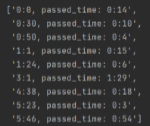

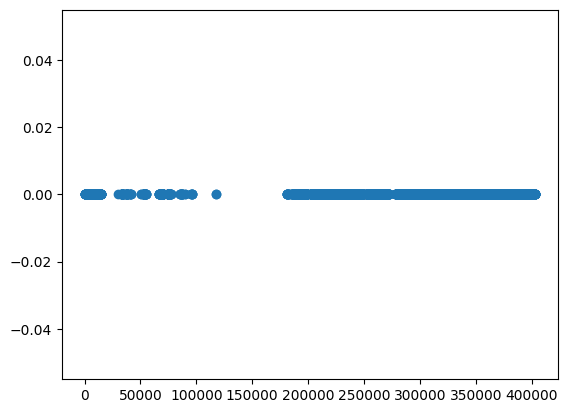

In [673]:
plt.scatter(violations[:, 1], y=[0]*len(violations))
plt.show()

In [649]:
df = pd.DataFrame(violations, columns=['Frame', 'Time', 'Bbox'])
df['Time'] = df['Time']/1000
df['center_x'] = df['Bbox'].apply(lambda x: (x[2]+x[0])/2)
df['center_x_cut'] = df['Bbox'].apply(lambda x: (x[2]+x[0])/2)
df['center_y'] = df['Bbox'].apply(lambda x: (x[3]+x[1])/2)
df

,Frame,Time,Bbox,center_x,center_y
0,1,0.0,"[1105.534912109375, 221.44403076171875, 1179.2...",1142.388611,277.853073
1,2,0.081189,"[1105.349609375, 221.49017333984375, 1178.8215...",1142.085571,277.827332
2,4,0.299611,"[1105.8907470703125, 221.54481506347656, 1180....",1142.959473,277.837410
3,6,0.453289,"[1107.01611328125, 221.91213989257812, 1178.49...",1142.756592,277.921310
4,7,0.519311,"[1107.1728515625, 222.1692657470703, 1178.8544...",1143.013672,278.171120
...,...,...,...,...,...
3539,4836,402.910733,"[983.0887451171875, 508.1997985839844, 1081.84...",1032.469238,565.730728
3540,4837,402.982133,"[982.7870483398438, 508.065185546875, 1081.879...",1032.333221,565.412720
3541,4838,403.069211,"[982.2351684570312, 507.8266296386719, 1081.29...",1031.765656,565.775925
3542,4839,403.192356,"[982.3419799804688, 508.00628662109375, 1080.9...",1031.655365,567.449066


In [716]:
df['Bbox'][0]

[1105.534912109375, 221.44403076171875, 1179.2423095703125, 334.2621154785156]

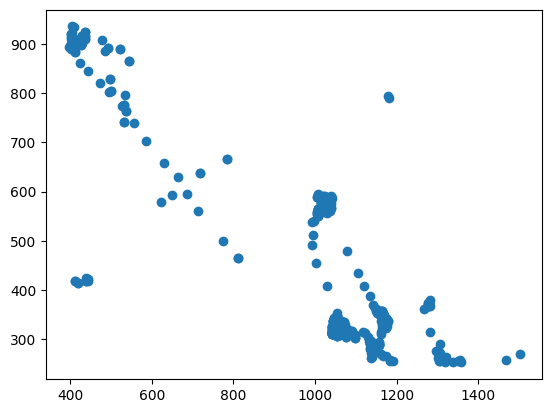

In [652]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']


plt.scatter(df['center_x'], y=df['center_y'])


In [699]:
#df2 = df[df['visible']==1]
df2 = df.copy()
df2

,Frame,Time,Bbox,center_x,center_y
0,1,0.0,"[1105.534912109375, 221.44403076171875, 1179.2...",1142.388611,277.853073
1,2,0.081189,"[1105.349609375, 221.49017333984375, 1178.8215...",1142.085571,277.827332
2,4,0.299611,"[1105.8907470703125, 221.54481506347656, 1180....",1142.959473,277.837410
3,6,0.453289,"[1107.01611328125, 221.91213989257812, 1178.49...",1142.756592,277.921310
4,7,0.519311,"[1107.1728515625, 222.1692657470703, 1178.8544...",1143.013672,278.171120
...,...,...,...,...,...
3539,4836,402.910733,"[983.0887451171875, 508.1997985839844, 1081.84...",1032.469238,565.730728
3540,4837,402.982133,"[982.7870483398438, 508.065185546875, 1081.879...",1032.333221,565.412720
3541,4838,403.069211,"[982.2351684570312, 507.8266296386719, 1081.29...",1031.765656,565.775925
3542,4839,403.192356,"[982.3419799804688, 508.00628662109375, 1080.9...",1031.655365,567.449066


In [706]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=10, min_samples=3, metric='euclidean', algorithm='auto', leaf_size=30, n_jobs=-1)

In [707]:
labels = dbscan.fit_predict(df2[['Time', 'center_x']])

In [708]:
df2.loc[:, 'labels'] = labels

In [709]:
df2.head()

,Frame,Time,Bbox,center_x,center_y,labels
0,1,0.0,"[1105.534912109375, 221.44403076171875, 1179.2...",1142.388611,277.853073,0
1,2,0.081189,"[1105.349609375, 221.49017333984375, 1178.8215...",1142.085571,277.827332,0
2,4,0.299611,"[1105.8907470703125, 221.54481506347656, 1180....",1142.959473,277.837410,0
3,6,0.453289,"[1107.01611328125, 221.91213989257812, 1178.49...",1142.756592,277.921310,0
4,7,0.519311,"[1107.1728515625, 222.1692657470703, 1178.8544...",1143.013672,278.171120,0


In [710]:
df3 = df2[df2['labels']>-1]


In [711]:
df4 = df3.iloc[:50]

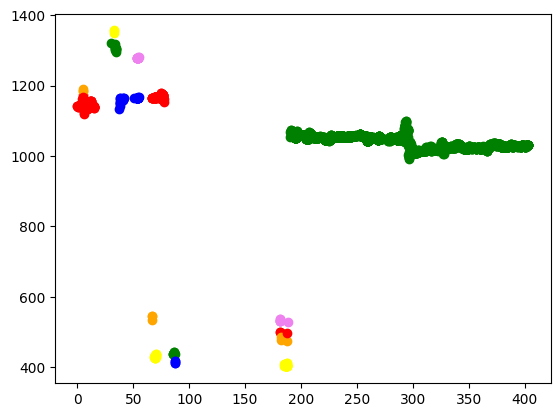

In [712]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']

for _, row in df3.iterrows():
    plt.scatter(row['Time'], y=row['center_x'], c=colors[int(row['labels'])%len(colors)])
plt.show()

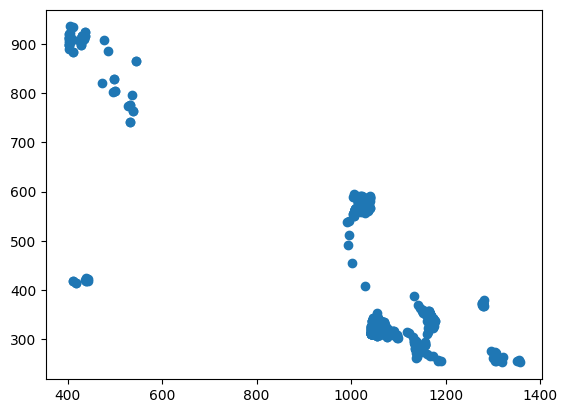

In [713]:
plt.scatter(df3['center_x'], y=df3['center_y'])

In [714]:
df4 = df3[['Frame', 'Time', 'labels']]
df4

,Frame,Time,labels
0,1,0.0,0
1,2,0.081189,0
2,4,0.299611,0
3,6,0.453289,0
4,7,0.519311,0
...,...,...,...
3539,4836,402.910733,15
3540,4837,402.982133,15
3541,4838,403.069211,15
3542,4839,403.192356,15


In [695]:
clusters_gb = df4.groupby('labels')
clusters = pd.DataFrame(df3['labels'].unique(), columns=['labels'])
clusters['min'] = clusters_gb.min().Time
clusters['max'] = clusters_gb.max().Time
clusters['count'] = clusters_gb.count().Time
clusters

,labels,min,max,count
0,0,0.0,15.080211,172
1,1,30.358878,41.278433,35
2,2,50.5291,54.698711,41
3,3,66.349667,77.069633,89
4,4,85.697678,89.851422,14
5,5,95.527011,96.017678,6
6,6,181.2054,272.083711,1496
7,7,277.905111,403.289711,1689


In [696]:
clusters = clusters[(clusters['max']-clusters['min']) >= 3]
clusters['minutes'] = clusters['min'] // 60
clusters['sex'] = clusters['min'] % 60
clusters

/tmp/ipykernel_29/1142546239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters['minutes'] = clusters['min'] // 60
/tmp/ipykernel_29/1142546239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clusters['sex'] = clusters['min'] % 60


,labels,min,max,count,minutes,sex
0,0,0.0,15.080211,172,0.0,0.0
1,1,30.358878,41.278433,35,0.0,30.358878
2,2,50.5291,54.698711,41,0.0,50.5291
3,3,66.349667,77.069633,89,1.0,6.349667
4,4,85.697678,89.851422,14,1.0,25.697678
6,6,181.2054,272.083711,1496,3.0,1.2054
7,7,277.905111,403.289711,1689,4.0,37.905111


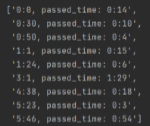

In [697]:
df5 = pd.merge(df3, clusters, how='inner', on='labels')
df5

,Frame,Time,Bbox,center_x,center_y,labels,min,max,count,minutes,sex
0,1,0.0,"[1105.534912109375, 221.44403076171875, 1179.2...",1142.388611,277.853073,0,0.0,15.080211,172,0.0,0.0
1,2,0.081189,"[1105.349609375, 221.49017333984375, 1178.8215...",1142.085571,277.827332,0,0.0,15.080211,172,0.0,0.0
2,4,0.299611,"[1105.8907470703125, 221.54481506347656, 1180....",1142.959473,277.837410,0,0.0,15.080211,172,0.0,0.0
3,6,0.453289,"[1107.01611328125, 221.91213989257812, 1178.49...",1142.756592,277.921310,0,0.0,15.080211,172,0.0,0.0
4,7,0.519311,"[1107.1728515625, 222.1692657470703, 1178.8544...",1143.013672,278.171120,0,0.0,15.080211,172,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3531,4836,402.910733,"[983.0887451171875, 508.1997985839844, 1081.84...",1032.469238,565.730728,7,277.905111,403.289711,1689,4.0,37.905111
3532,4837,402.982133,"[982.7870483398438, 508.065185546875, 1081.879...",1032.333221,565.412720,7,277.905111,403.289711,1689,4.0,37.905111
3533,4838,403.069211,"[982.2351684570312, 507.8266296386719, 1081.29...",1031.765656,565.775925,7,277.905111,403.289711,1689,4.0,37.905111
3534,4839,403.192356,"[982.3419799804688, 508.00628662109375, 1080.9...",1031.655365,567.449066,7,277.905111,403.289711,1689,4.0,37.905111


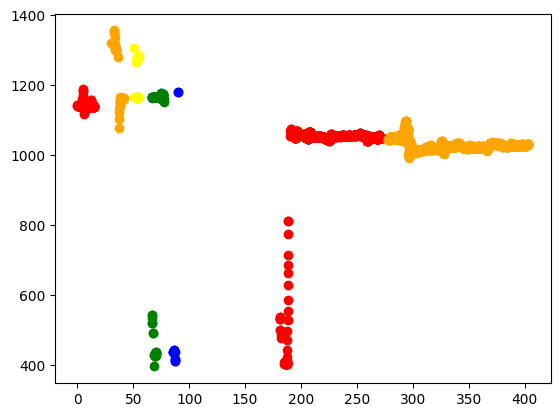

In [698]:
colors = ['red', 'orange', 'yellow', 'green', 'blue', 'violet']

for _, row in df5.iterrows():
    plt.scatter(row['Time'], y=row['center_x'], c=colors[int(row['labels'])%len(colors)])
plt.show()

In [672]:
out = pd.DataFrame(data=[DATA_PATH.split('/')[-1],
                    len(clusters),
                    list(clusters['min'])], columns=['filename', 'cases_count', 'timestamps'])
out

ValueError: Shape of passed values is (3, 1), indices imply (3, 3)

In [671]:
list(clusters['min'])

[0.0,
 30.358877777777778,
 50.5291,
 66.34966666666665,
 85.69767777777778,
 181.2054,
 277.9051111111111]